In [1]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

In [37]:
import numpy as np
import pandas as pd  # read_csv, get_dummies(원핫인코딩)
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # 스케일 조정
from sklearn.model_selection import train_test_split  # 훈련셋과 시험셋 분리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.activations import relu, softmax  # activation='relu' 대신 사용
from tensorflow.keras import metrics  # metrics=['accuracy']
import matplotlib.pyplot as plt

- Red Wine 품질 등급 예측

1. 데이터셋 확보 & 전처리 <br>
    독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies), 훈련셋과 테스트셋 분리(train_test_split)
2. 모델 구성하기 (입력11, 출력6) layer층 4개
3. 모델 학습 과정 설정 (다중분류에 맞는 설정)
4. 모델 학습시키기 (callbacks-EarlyStopping 이용)
5. 모델 평가하기 - 그래프, 평가(테스트셋), 교차표(crosstab)
6. 모델 저장 및 모델 사용하기

# 1. 데이터셋 확보 & 전처리
 - 독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies), 훈련셋과 테스트셋 분리(train_test_split)

In [3]:
# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)

redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [4]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [38]:
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)

In [5]:
redwine.info()
# 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
# 독립변수, 종속변수 분리
X = redwine.iloc[:, :-1]
Y = redwine.iloc[:, -1:]
X.shape, Y.shape

((1599, 11), (1599, 1))

In [39]:
# X_redwine = redwine.iloc[:,:-1]
# y_redwine = redwine.iloc[:,-1]
# X_redwine.shape, y_redwine.shape

In [7]:
# 독립변수 스케일조정(StandardScaler)
scaler = MinMaxScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X))
print(X.shape, scaled_X.shape)
scaled_X.head()

(1599, 11) (1599, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846


In [40]:
# 독립변수 스케일조정(StandardScaler)
# scaler = StandardScaler()
# scaler.fit(X_redwine.to_numpy()) # values와 to_numpy() 동일
# scaled_X_redwine = scaler.transform(X_redwine.values)
# scaled_X_redwine[:2]

In [8]:
# 훈련셋과 테스트셋 분리(train_test_split)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 1), (480, 11), (480, 1))

In [42]:
# 훈련셋과 테스트셋 분리(train_test_split) - 7:3분리
# X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine, 
#                                 Y_redwine,
#                                 test_size=0.3, 
#                                 random_state=1,
#                                 stratify=Y_redwine) # 층화추출(등급별 7:3으로 추출)
# print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

In [9]:
# 종속변수 원핫인코딩(get_dummies)
Y_train = pd.get_dummies(Y_train['quality']).values
Y_test = pd.get_dummies(Y_test['quality']).values
print(Y_train.shape, Y_test.shape)


(1119, 6) (480, 6)


In [41]:
# 종속변수 원핫인코딩(get_dummies)
# Y_redwine = pd.get_dummies(y_redwine).to_numpy() 
# Y_redwine[:2]

In [10]:
print(Y_train[3])
print(Y_train[3].argmax() + 3)

[0 0 0 1 0 0]
6


In [43]:
# 층화추출을 하면 등급별 7:3으로  shuffle 되서 추출
# np.c_[pd.Series(Y_train.argmax(axis=1)).value_counts(),
#       pd.Series(Y_test.argmax(axis=1)).value_counts()]

# 2. 모델 구성하기 (입력11, 출력6) layer층 4개

In [19]:
model = Sequential()
model.add(Input(shape=11, ))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=128,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=64,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=6,   activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 11)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                384       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)               

In [44]:
# model = Sequential()
# model.add(Input(11)) # 의미있는 레이어가 아니고 input_dim만 지정
# model.add(Dense(units=32, activation=relu))
# model.add(Dense(units=64, activation=relu))
# model.add(Dropout(0.1))
# model.add(Dense(units=16, activation=relu))
# model.add(Dense(units=6, activation=softmax)) # 3 4 5 6 7 8 등급의 결과 합이 1
# model.summary()

# 3. 모델 학습 과정 설정 (다중분류에 맞는 설정)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# 4. 모델 학습시키기 (callbacks-EarlyStopping) 이용

In [21]:
earlyStopping = EarlyStopping(patience=10)
hist = model.fit(X_train, Y_train,
                 epochs=1500,
                 batch_size=300,
                 validation_data=(X_test, Y_test),
                 callbacks=[earlyStopping])

Epoch 1/1500
4/4 [==============================] - 1s 84ms/step - loss: 1.7550 - accuracy: 0.3432 - val_loss: 1.7167 - val_accuracy: 0.4729
Epoch 2/1500
4/4 [==============================] - 0s 11ms/step - loss: 1.6790 - accuracy: 0.4397 - val_loss: 1.6273 - val_accuracy: 0.4750
Epoch 3/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.5764 - accuracy: 0.4477 - val_loss: 1.5163 - val_accuracy: 0.4583
Epoch 4/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.4578 - accuracy: 0.4441 - val_loss: 1.3971 - val_accuracy: 0.4563
Epoch 5/1500
4/4 [==============================] - 0s 17ms/step - loss: 1.3485 - accuracy: 0.4549 - val_loss: 1.2993 - val_accuracy: 0.4500
Epoch 6/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.2736 - accuracy: 0.4576 - val_loss: 1.2355 - val_accuracy: 0.4604
Epoch 7/1500
4/4 [==============================] - 0s 17ms/step - loss: 1.2291 - accuracy: 0.4602 - val_loss: 1.1973 - val_accuracy: 0.4688
Epoch 8/1500


Epoch 59/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0076 - accuracy: 0.5809 - val_loss: 0.9829 - val_accuracy: 0.5583
Epoch 60/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0136 - accuracy: 0.5585 - val_loss: 0.9800 - val_accuracy: 0.5375
Epoch 61/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0017 - accuracy: 0.5845 - val_loss: 0.9781 - val_accuracy: 0.5375
Epoch 62/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0173 - accuracy: 0.5603 - val_loss: 0.9827 - val_accuracy: 0.5583
Epoch 63/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0159 - accuracy: 0.5728 - val_loss: 0.9803 - val_accuracy: 0.5542
Epoch 64/1500
4/4 [==============================] - 0s 16ms/step - loss: 1.0118 - accuracy: 0.5684 - val_loss: 0.9787 - val_accuracy: 0.5479
Epoch 65/1500
4/4 [==============================] - 0s 15ms/step - loss: 1.0050 - accuracy: 0.5684 - val_loss: 0.9787 - val_accuracy: 0.5417
Epoch 

In [45]:
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 자동 호출
#     def __init__(self): # 생성자 함수
#         self.epoch = 0
#     def on_epoch_end(self, batch, logs={}):
#         self.epoch += 1
#         if self.epoch%5 ==0:
#             print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.\
#                  format(self.epoch, 
#                         logs.get('loss'), 
#                         logs.get('accuracy'),
#                         logs.get('val_loss'),
#                         logs.get('val_accuracy')
#                        ))
# customHistory = CustomHistory()
# earlyStropping = EarlyStopping(patience=20)
# hist = model.fit(X_train, Y_train, epochs=100, batch_size=200, 
#                  validation_split=0.2, 
#                  callbacks=[earlyStropping, 
#                            customHistory
#                            ],
#                 verbose=0)

# 5. 모델 평가하기 - 그래프, 평가(테스트셋), 교차표(crosstab)

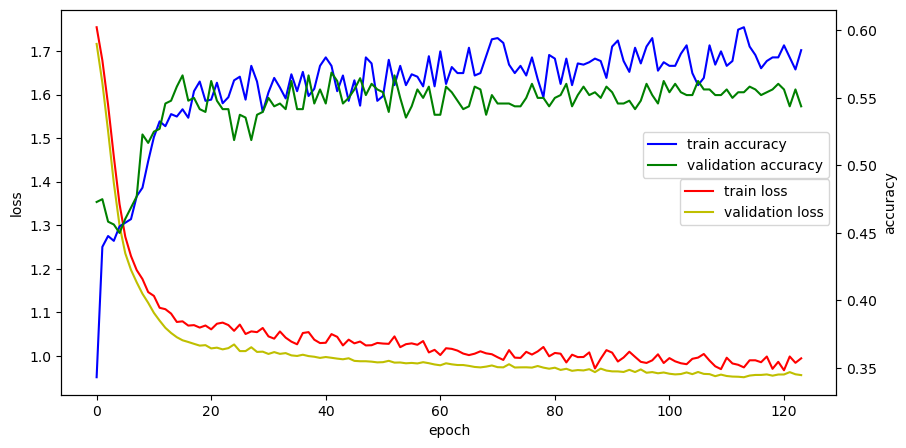

In [46]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [48]:
# 모델 평가하기
# loss_and_acc = model.evaluate(X_test, Y_test, batch_size=32)
# print('loss : ', loss_and_acc[0])
# print('accuracy : ', loss_and_acc[1])

In [49]:
# 7. 성능 지표(crosstab)
# # pred = model.predict(X_test).argmax(axis=1)+3
# pred = np.argmax(model.predict(X_test), axis=1)+3
# # real = Y_test.argmax(axis=1) + 3
# real = np.argmax(Y_test, axis=1) +3
# cross_tab = pd.crosstab(real, pred)
# cross_tab.index.name = "real"
# cross_tab.columns.name = 'predict'
# cross_tab

In [27]:
Y_test.argmax(axis=1) + 3

array([6, 5, 6, 5, 6, 5, 5, 5, 5, 6, 7, 3, 5, 5, 6, 7, 5, 7, 8, 5, 5, 6,
       5, 6, 6, 6, 7, 6, 5, 6, 5, 5, 6, 5, 6, 5, 7, 5, 4, 6, 5, 5, 7, 5,
       5, 6, 7, 6, 5, 6, 5, 5, 5, 7, 6, 6, 6, 5, 5, 5, 5, 7, 5, 6, 6, 5,
       6, 5, 6, 5, 6, 4, 6, 6, 6, 5, 8, 5, 6, 6, 5, 6, 5, 6, 6, 7, 5, 6,
       7, 4, 7, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5, 5, 5, 7, 6, 7, 6, 5, 6, 5,
       8, 5, 6, 5, 6, 7, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 7, 6, 5, 5, 6, 5,
       5, 5, 6, 5, 5, 5, 5, 6, 7, 6, 8, 5, 5, 5, 6, 6, 6, 5, 6, 7, 6, 5,
       6, 5, 5, 6, 6, 6, 7, 5, 7, 5, 5, 5, 6, 6, 5, 5, 6, 5, 7, 6, 7, 6,
       6, 5, 5, 6, 4, 6, 5, 7, 5, 5, 4, 5, 7, 6, 5, 6, 6, 7, 6, 5, 5, 6,
       5, 7, 5, 6, 6, 5, 7, 5, 5, 5, 6, 7, 7, 5, 5, 6, 6, 7, 6, 5, 6, 6,
       6, 6, 6, 7, 4, 5, 5, 7, 5, 5, 5, 5, 6, 6, 5, 7, 5, 6, 6, 6, 5, 4,
       6, 7, 6, 7, 5, 6, 6, 5, 5, 6, 5, 6, 4, 5, 6, 6, 5, 6, 6, 5, 5, 6,
       7, 7, 6, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 6, 6, 6, 7, 5, 5, 6, 5, 7,
       5, 6, 4, 6, 6, 8, 6, 5, 5, 6, 5, 7, 6, 6, 5,

In [28]:
Y_hat = model.predict(X_test).argmax(axis=1) + 3
Y_hat

15/15 [==============================] - 0s 1ms/step


array([5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 6, 5, 6, 5, 5, 7, 5, 5, 7, 5, 5, 5,
       6, 7, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5,
       6, 6, 6, 5, 5, 6, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 7, 5,
       7, 5, 7, 5, 7, 5, 6, 6, 6, 5, 7, 6, 6, 6, 5, 7, 5, 6, 6, 6, 5, 6,
       6, 5, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 5,
       7, 5, 6, 5, 6, 6, 6, 5, 5, 6, 7, 5, 6, 5, 5, 5, 6, 6, 5, 6, 6, 5,
       5, 7, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6, 6, 5, 6,
       6, 6, 5, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6,
       6, 5, 5, 5, 5, 6, 5, 7, 5, 7, 5, 6, 7, 5, 6, 6, 5, 7, 6, 5, 5, 5,
       6, 6, 5, 5, 5, 5, 7, 6, 5, 5, 6, 6, 6, 5, 6, 6, 7, 6, 5, 5, 6, 5,
       5, 6, 7, 6, 5, 5, 5, 7, 5, 5, 5, 5, 7, 6, 6, 6, 5, 6, 5, 5, 6, 5,
       6, 6, 5, 5, 6, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 6, 6, 5, 7,
       6, 6, 5, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 7, 5, 6, 5, 5, 6,
       5, 6, 5, 6, 5, 7, 5, 5, 5, 6, 5, 6, 6, 7, 5,

In [33]:
ctab = pd.crosstab(Y_test.argmax(axis=1) + 3, Y_hat)
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab

예측값,5,6,7
실제값,,,
3,1,0,0
4,13,4,0
5,150,43,2
6,80,98,22
7,4,44,13
8,0,2,4


# 6. 모델 저장 및 모델 사용하기

In [34]:
model.save('model/wine_quality_grade_predict.h5')

In [35]:
from tensorflow.keras.models import load_model
model2 = load_model('model/wine_quality_grade_predict.h5')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 11)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                384       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)               

In [36]:
model2.evaluate(X_test, Y_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.9555 - accuracy: 0.5437


[0.955521285533905, 0.543749988079071]

In [50]:
input_data = np.array([[10.5, 0.39, 0.46, 2.2, 0.075, 14.0, 27.0, 0.99598, 3.06, 0.84,11.4]])
scaled_input_data = scaler.transform(input_data)
np.argmax(model.predict(scaled_input_data), axis=1) + 3

1/1 [==============================] - 0s 72ms/step


C:\Users\4545\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([6], dtype=int64)